In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#### loading data

In [2]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

#### getting dummies on *Churn*

In [3]:
data = pd.get_dummies(data, columns=["Churn"], drop_first=True)

#### manually cleaning *TotalCharges*

In [4]:
data = data[data["TotalCharges"] != " "]
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="ignore")

#### splitting dataset into train and test sets

In [5]:
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=44)

data = train_set.drop(["customerID", "Churn_Yes"], axis=1)
data_labels = train_set["Churn_Yes"].copy()

#### preparing data to pipeline

In [6]:
data_num = data[["tenure", "MonthlyCharges", "TotalCharges"]]
data_cat = data.drop(columns=["tenure", "MonthlyCharges", "TotalCharges"])

#### pipeline

In [7]:
num_attribs = list(data_num)
cat_attribs = list(data_cat)

full_pipeline = ColumnTransformer([
    ("num", Pipeline([
        ("poly", PolynomialFeatures(degree=3,
                                    include_bias=False,
                                    interaction_only=False)),
        ("scaler", StandardScaler()),
    ]), num_attribs),
    ("cat", OneHotEncoder(drop="first"), cat_attribs),
])

new_data = full_pipeline.fit_transform(data)

#### preparing own transformation class

In [8]:
class DropTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold = 0.8):
        self.threshold = threshold
        print("It works!")
        
    def fit(self, X, y = None):
        
        return self
    
    def transform(self, X):

        data = pd.DataFrame(X)
        corr_matrix = data.corr(method="spearman")
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        transformed_data = np.array(data.drop(data.columns[to_drop], axis=1))
        
        return transformed_data

In [9]:
pipeline = Pipeline([("droper", DropTransformer(threshold = 0.95))])

data_prepared = pipeline.fit_transform(new_data)

It works!


C:\Users\nemet\AppData\Local\Temp\ipykernel_71192\3859277870.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


#### splitting prepared data into train and val sets

In [10]:
X_train, X_val, y_train, y_val = train_test_split(data_prepared, data_labels, test_size = 0.25,
                                                  random_state=44, stratify=data_labels)

#### learning KNN base model

In [11]:
knn_classifier = KNeighborsClassifier()

knn_classifier.fit(X_train, y_train);

#### checking model

In [12]:
y_pred = knn_classifier.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      3102
           1       0.72      0.67      0.69      1116

    accuracy                           0.84      4218
   macro avg       0.80      0.79      0.79      4218
weighted avg       0.84      0.84      0.84      4218



In [13]:
y_val_pred = knn_classifier.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1035
           1       0.55      0.56      0.56       372

    accuracy                           0.76      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.77      0.76      0.77      1407



In [14]:
scores = cross_val_score(knn_classifier, X_train, y_train,
                        scoring = "f1", cv=10)
scores

array([0.52534562, 0.54545455, 0.55707763, 0.5412844 , 0.52914798,
       0.6       , 0.44230769, 0.5862069 , 0.51351351, 0.53744493])

In [15]:
print(scores.mean(), scores.std())

0.5377783215171277 0.04073466850957446


### slytherin

In [16]:
from sklearn.metrics import confusion_matrix, make_scorer
from collections import Counter

In [17]:
basic_medians = [64.45, 79.65]
basic_discount = 1 - basic_medians[0] / basic_medians[1]

In [18]:
def function(y_true, y_pred, medians = basic_medians, discount = basic_discount, basic = True, scoring_only = True):
    
    """
    Jeśli interesuje Cie wartość dodana przyjmij scoring_only = False. Wówczas poza scorem otrzymasz także:
        base_case - najlepszy możliwy scenariusz dla firmy
        standard_case - aktualny scenariusz firmy (bez naszej ingerencji)
        model_vase - scenariusz oparty na naszym modelu

    Jeśli chcesz manipulować zmiennymi medians i discount, pamiętaj aby przyjąć basic = False
    """
    
    
    matrix = confusion_matrix(y_true, y_pred)
    TN = matrix[0][0]
    FP = matrix[0][1]
    FN = matrix[1][0]
    TP = matrix[1][1]
    
    if basic:
        basic_score = 1 - (medians[1]/medians[0]*FN + medians[0]/medians[1]*FP)/(TN + TP)
        
        if scoring_only:
            return basic_score
        else:
            best_case = round(medians[0] * Counter(y_true)[0] + medians[1] * Counter(y_true)[1], 2)
            standard_case = round(medians[0] * Counter(y_true)[0] - medians[1] * Counter(y_true)[1], 2)
            model_case = round(basic_score * medians[0]*(TN+TP), 2)
            return basic_score, best_case, standard_case, model_case
    
    else:
        score = 1 - (medians[1]*FN + (1 - discount)*medians[0]*FP)/(medians[0]*TN + (1- discount)*medians[1]*TP)
        
        if scoring_only:
            return score
        else:
            best_case = round(medians[0] * Counter(y_true)[0] + medians[1] * Counter(y_true)[1], 2)
            standard_case = round(medians[0] * Counter(y_true)[0] - medians[1] * Counter(y_true)[1], 2)
            model_case = round(score * (medians[0]*TN + (1- discount)*medians[1]*TP), 2)
            return score, best_case, standard_case, model_case

In [19]:
slytherin_score = make_scorer(function, greater_is_better=True)

#### hyperparameters

n_neighbors

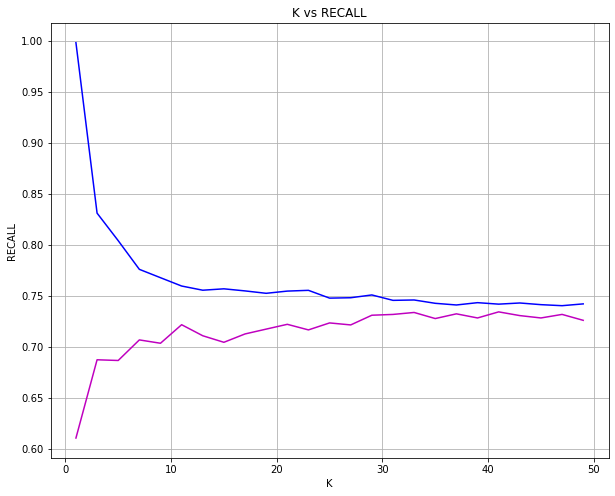

In [21]:
train_scores = []
val_scores = []

neighbors = list(range(1, 50, 2))

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_train)
    val_pred = knn.predict(X_val)
    train_scores.append(function(y_train, pred))
    val_scores.append(function(y_val, val_pred))              
    
plt.figure(figsize = (10, 8))
plt.xlabel('K')
plt.ylabel('RECALL')
plt.title('K vs RECALL')
plt.plot(neighbors, train_scores, 'b')
plt.plot(neighbors, val_scores, 'm')
plt.grid()

#### GridSearchCV

In [23]:
%%time

grid_params = {
    "n_neighbors": [31, 33, 35],
    "weights": ["uniform", "distance"],
    "metric": ["minkowski", "euclidean", "manhattan"],
    "leaf_size": list(range(10, 50, 10)),
    "p": [1, 2]
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    scoring = "f1",
    verbose = 1,
    cv = 10,
    n_jobs = -1
)

gs_results = gs.fit(X_train, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
CPU times: total: 2.22 s
Wall time: 19.2 s


#### learning best model

In [26]:
gs_results.best_params_

{'leaf_size': 10,
 'metric': 'minkowski',
 'n_neighbors': 35,
 'p': 2,
 'weights': 'uniform'}

In [27]:
best_classifier = KNeighborsClassifier(n_neighbors = 33,
                                       leaf_size = 10,
                                       p = 2,
                                       metric = "minkowski",
                                       weights = "uniform")

best_classifier.fit(X_train, y_train);

#### checking model

In [28]:
y_pred = best_classifier.predict(X_val)

In [29]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1035
           1       0.61      0.60      0.61       372

    accuracy                           0.79      1407
   macro avg       0.74      0.73      0.73      1407
weighted avg       0.79      0.79      0.79      1407



In [30]:
slytherin_score(best_classifier, X_val, y_val)

0.7335865749624509

In [31]:
function(y_val, y_pred, scoring_only=False)

(0.7335865749624509, 96335.55, 37075.95, 52858.65)

#### threshold calibration

Best Threshold=0.393939, G-Mean=0.756


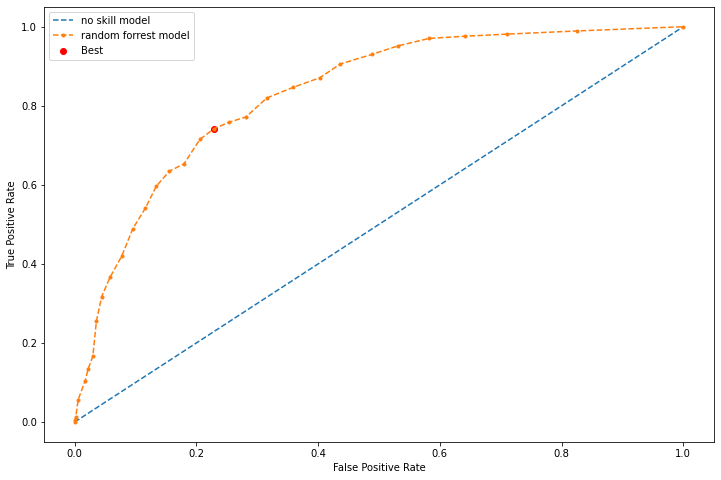

In [32]:
fpr, tpr, thresholds = roc_curve(y_val, best_classifier.predict_proba(X_val)[:,1])

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

plt.figure(figsize = (12, 8))
plt.plot([0,1], [0,1], linestyle='--', label='no skill model')
plt.plot(fpr, tpr, marker='.', linestyle='--', label='random forrest model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [33]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [34]:
threshold = thresholds[ix]
print(classification_report(y_val, to_labels(best_classifier.predict_proba(X_val)[:,1], threshold)))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1035
           1       0.54      0.74      0.62       372

    accuracy                           0.76      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.76      0.77      1407

